In [1]:
from autogluon.tabular import TabularPredictor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load the city data.
# *                                                                                              *
# *You will have to download this yourself since you need to accept the Creative Commons license.*
# *                                                                                              *
# This is from https://simplemaps.com/data/us-cities
# The license is Creative Commons Attribution 4.0
# and requires that the above attribution message be maintained when you use this city data.
uscities_full = pd.read_csv('uscities.csv')
# Let's limit to the larger cities (top ~1000) and remove the long list of zip codes which makes printing the data difficult.
uscities_full = uscities_full.drop(columns=['zips'])
print(uscities_full.shape)
uscities_full.head()

(28338, 16)


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715,polygon,False,True,America/New_York,1,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276,polygon,False,True,America/Los_Angeles,1,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203,4574,polygon,False,True,America/Chicago,1,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7839,-80.2102,6445545,5019,polygon,False,True,America/New_York,1,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7936,-96.7662,5743938,1526,polygon,False,True,America/Chicago,1,1840019440


In [3]:
uscities = uscities_full[['city_ascii', 'state_id', 'lat', 'lng']]



In [4]:
import time

add_sentence_embeddings_bert =True
pca_sentence_embeddings = True
pca_vectors=64
sentence_transformer_pretrained_model = 'average_word_embeddings_glove.6B.300d'

start_time = time.time()
# For bert you probably  need to
# pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.1+cpu.html
# first using pip3 list | grep torch to check your  torch version
#
if add_sentence_embeddings_bert:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer(sentence_transformer_pretrained_model)

    embed_input = 'The city of ' + uscities['city_ascii'] + ' in the state of ' + uscities['state_id']
    sentence_embeddings = model.encode(embed_input)

    print('Raw embeddings are of shape {}'.format(sentence_embeddings.shape))
    if pca_sentence_embeddings:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=pca_vectors)
        pca.fit(sentence_embeddings)
        sentence_embeddings = pca.transform(sentence_embeddings)
        
    uscities = pd.concat([uscities, pd.DataFrame(data=sentence_embeddings, index=uscities.index.values)], axis=1)

print('Embeddings+PCA took {} seconds'.format(time.time() - start_time))
uscities.head()
    

2022-01-27 01:30:13.388693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-27 01:30:13.388742: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Raw embeddings are of shape (28338, 300)
Embeddings+PCA took 5.902237892150879 seconds


,city_ascii,state_id,lat,lng,0,1,2,3,4,5,...,54,55,56,57,58,59,60,61,62,63
0,New York,NY,40.6943,-73.9249,0.849400,0.820012,1.254539,0.353356,0.413352,-0.441414,...,0.115718,-0.043004,-0.186794,-0.074524,-0.250480,-0.105797,0.218940,0.127640,0.065303,0.162738
1,Los Angeles,CA,34.1139,-118.4068,1.305180,-0.635574,0.122969,0.887418,-0.018170,0.369131,...,-0.192679,0.045329,-0.164545,-0.131394,0.117773,0.417241,0.060492,-0.074484,0.149372,0.090392
2,Chicago,IL,41.8373,-87.6862,0.932879,-0.076213,-0.331472,-0.617394,1.546453,0.072476,...,-0.227695,0.065947,-0.233423,-0.080785,-0.022251,0.100657,-0.053228,0.103927,0.082764,0.133233
3,Miami,FL,25.7839,-80.2102,0.186374,-0.068976,0.157924,0.724347,0.113665,0.242771,...,-0.035613,0.254677,-0.163365,-0.080092,-0.148765,0.090375,-0.127517,0.129877,-0.219338,-0.010885
4,Dallas,TX,32.7936,-96.7662,-0.095742,-0.128844,-0.239895,1.512355,0.865581,1.117618,...,-0.095912,0.123415,-0.147883,-0.042154,-0.058274,0.078092,-0.117930,0.021670,-0.056879,-0.154059


In [5]:
# Split into parallel datasets, one to predict just latitude, one to predict just longitude.
# This is until AutoGluon does multiclass prediction.
uscities_lat = uscities.drop(columns=['lng'])
uscities_lng = uscities.drop(columns=['lat'])
uscities_lat.head()

,city_ascii,state_id,lat,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
0,New York,NY,40.6943,0.849400,0.820012,1.254539,0.353356,0.413352,-0.441414,0.668698,...,0.115718,-0.043004,-0.186794,-0.074524,-0.250480,-0.105797,0.218940,0.127640,0.065303,0.162738
1,Los Angeles,CA,34.1139,1.305180,-0.635574,0.122969,0.887418,-0.018170,0.369131,-0.358112,...,-0.192679,0.045329,-0.164545,-0.131394,0.117773,0.417241,0.060492,-0.074484,0.149372,0.090392
2,Chicago,IL,41.8373,0.932879,-0.076213,-0.331472,-0.617394,1.546453,0.072476,0.347811,...,-0.227695,0.065947,-0.233423,-0.080785,-0.022251,0.100657,-0.053228,0.103927,0.082764,0.133233
3,Miami,FL,25.7839,0.186374,-0.068976,0.157924,0.724347,0.113665,0.242771,-0.320557,...,-0.035613,0.254677,-0.163365,-0.080092,-0.148765,0.090375,-0.127517,0.129877,-0.219338,-0.010885
4,Dallas,TX,32.7936,-0.095742,-0.128844,-0.239895,1.512355,0.865581,1.117618,0.355080,...,-0.095912,0.123415,-0.147883,-0.042154,-0.058274,0.078092,-0.117930,0.021670,-0.056879,-0.154059


In [6]:
# Standard train_test split.
# Let's only train on 50% of the data so we're left with some large, recognisable cities in the test set.
X_lat_train, X_lat_test, y_lat_train, y_lat_test = train_test_split(uscities_lat.drop(columns='lat'), uscities_lat['lat'], 
                                                                    test_size=0.5, random_state=42)
X_lng_train, X_lng_test, y_lng_train, y_lng_test = train_test_split(uscities_lng.drop(columns='lng'), uscities_lng['lng'], 
                                                                    test_size=0.5, random_state=42)

uscities_lat_train=pd.concat([X_lat_train, y_lat_train], axis=1)
uscities_lng_train=pd.concat([X_lng_train, y_lng_train], axis=1)
uscities_lat_test=pd.concat([X_lat_test, y_lat_test], axis=1)
uscities_lng_test=pd.concat([X_lng_test, y_lng_test], axis=1)

In [19]:
time_limit=600
predictor_lat = TabularPredictor(label='lat', eval_metric='mean_absolute_error').fit(train_data=uscities_lat_train, time_limit=time_limit)
predictor_lng = TabularPredictor(label='lng', eval_metric='mean_absolute_error').fit(train_data=uscities_lng_train, time_limit=time_limit)


No path specified. Models will be saved in: "AutogluonModels/ag-20220127_013957/"
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220127_013957/"
AutoGluon Version:  0.3.2b20220115
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    14169
Train Data Columns: 66
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (71.2728, 17.9608, 38.62721, 5.8819)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    30006.36 MB
	Train Data (Original)  Memory Usage: 5.4 MB (0.0% of available memory)
	Infer

	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])  : 64 | ['0', '1', '2', '3', '4', ...]
		('object', []) :  2 | ['city_ascii', 'state_id']
	Types of features in processed data (raw dtype, special dtypes):
		('category', []) :  2 | ['city_ascii', 'state_id']
		('float', [])    : 64 | ['0', '1', '2', '3', '4', ...]
	0.2s = Fit runtime
	66 features in original data used to generate 66 features in processed data.
	Train Data (Processed) Memory Usage: 3.67 MB (0.0% of available memory)
Data preprocessing a

In [20]:
y_lat_pred = predictor_lat.predict(X_lat_test)
y_lng_pred = predictor_lng.predict(X_lng_test)
predictor_lat.leaderboard(uscities_lat_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.933144,-0.934705,5.329488,0.712918,64.120540,0.004632,0.000513,0.282327,2,True,11
1,LightGBMXT,-0.939053,-0.945354,0.099372,0.013140,1.896822,0.099372,0.013140,1.896822,1,True,3
2,LightGBM,-0.948143,-0.954133,0.051225,0.009525,1.689772,0.051225,0.009525,1.689772,1,True,4
3,LightGBMLarge,-0.952012,-0.969870,0.124109,0.015613,6.821408,0.124109,0.015613,6.821408,1,True,10
4,CatBoost,-0.989845,-0.990287,0.035707,0.012568,36.396190,0.035707,0.012568,36.396190,1,True,6
5,NeuralNetFastAI,-1.010585,-1.015885,0.236474,0.045107,16.997320,0.236474,0.045107,16.997320,1,True,8
6,XGBoost,-1.047728,-1.047428,0.239905,0.017241,8.110923,0.239905,0.017241,8.110923,1,True,9
7,KNeighborsDist,-1.092060,-1.124796,4.777970,0.616453,0.036701,4.777970,0.616453,0.036701,1,True,2
8,KNeighborsUnif,-1.092217,-1.131194,4.785654,0.542141,0.036589,4.785654,0.542141,0.036589,1,True,1
9,RandomForestMSE,-1.104873,-1.118898,0.466760,0.105273,45.346983,0.466760,0.105273,45.346983,1,True,5


In [22]:
predictor_lat.evaluate(uscities_lat_test, auxiliary_metrics=True)

Evaluation: mean_absolute_error on test data: -0.9331442557278968
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "mean_absolute_error": -0.9331442557278968,
    "root_mean_squared_error": -1.239488472129398,
    "mean_squared_error": -1.5363316725416694,
    "r2": 0.9552562638841574,
    "pearsonr": 0.9773893615873457,
    "median_absolute_error": -0.741542810058597
}


{'mean_absolute_error': -0.9331442557278968,
 'root_mean_squared_error': -1.239488472129398,
 'mean_squared_error': -1.5363316725416694,
 'r2': 0.9552562638841574,
 'pearsonr': 0.9773893615873457,
 'median_absolute_error': -0.741542810058597}

In [23]:
# Let's view the accuracy of ground truth vs predicted latitude
pd.concat([X_lat_test, y_lat_test, y_lat_pred, uscities_full['population']], axis=1, join='inner').sort_values(by='population',ascending=False).head(10)

,city_ascii,state_id,0,1,2,3,4,5,6,7,...,57,58,59,60,61,62,63,lat,lat,population
0,New York,NY,0.849400,0.820012,1.254539,0.353356,0.413352,-0.441414,0.668698,0.115490,...,-0.074524,-0.250480,-0.105797,0.218940,0.127640,0.065303,0.162738,40.6943,41.370739,18713220
3,Miami,FL,0.186374,-0.068976,0.157924,0.724347,0.113665,0.242771,-0.320557,-0.076743,...,-0.080092,-0.148765,0.090375,-0.127517,0.129877,-0.219338,-0.010885,25.7839,27.612795,6445545
4,Dallas,TX,-0.095742,-0.128844,-0.239895,1.512355,0.865581,1.117618,0.355080,0.030322,...,-0.042154,-0.058274,0.078092,-0.117930,0.021670,-0.056879,-0.154059,32.7936,31.593708,5743938
5,Philadelphia,PA,0.520321,1.273114,0.477795,-0.439692,-0.092323,0.906056,-0.386532,-0.406015,...,-0.036710,0.072137,0.098830,-0.107690,0.004620,-0.016923,-0.033236,40.0077,40.484615,5649300
6,Houston,TX,-0.042702,-0.095699,-0.285833,1.544666,0.748828,1.230836,0.339974,0.070358,...,-0.094338,-0.046712,0.103728,-0.084703,-0.038878,-0.063324,-0.110179,29.7863,30.975523,5464251
7,Atlanta,GA,0.278316,0.303497,-0.212595,0.348060,-0.230415,0.897927,-0.468592,-0.022138,...,-0.016176,-0.097355,0.041977,-0.056767,-0.114438,0.108476,0.059416,33.7627,32.945282,5449398
8,Washington,DC,0.825931,0.455062,0.069215,0.311338,-0.015801,-0.006540,-0.066766,0.055105,...,0.032943,-0.249743,0.048199,-0.197118,0.086892,-0.074150,0.352517,38.9047,40.967346,5379184
14,San Diego,CA,1.121414,-0.854580,0.077902,0.905863,0.028051,0.391101,-0.330065,-0.263663,...,0.179175,0.235444,-0.125288,0.022909,-0.081493,-0.073640,-0.218907,32.8312,36.192608,3220118
17,Denver,CO,1.219574,0.224865,-0.248714,0.926486,0.175036,-0.127832,0.268608,-0.028732,...,-0.097381,-0.147301,0.140646,-0.329812,-0.038112,0.091179,-0.223758,39.7621,39.576996,2876625
19,Queens,NY,0.319038,0.889196,1.247328,0.113025,0.170275,-0.553993,0.779106,0.120986,...,-0.118331,-0.094921,0.103083,0.254265,0.063784,0.068867,0.038421,40.7498,41.478279,2230722


In [24]:
# Now let's plot the predicted location of some cities to understand what the model has done.
# First load the shapefile that contains the outline of US states.
from os.path import exists
import requests
import zipfile
import matplotlib.pyplot as plt
import geopandas
url = 'https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip'
filenamezip = url.split('/')[-1]
filenameshp = 'shp/' + filenamezip.replace('zip','shp')
if not exists(filenameshp):
    print('Downloading:'+url)
    r = requests.get(url)
    print('Writing:'+filenamezip)
    with open(filenamezip, 'wb') as f:
        f.write(r.content) 
    print('Unzipping to:'+filenameshp)
    with zipfile.ZipFile(filenamezip, 'r') as zip_ref:
        zip_ref.extractall('shp')
else:
    print('Already present:'+filenameshp)

Already present:shp/cb_2020_us_state_20m.shp


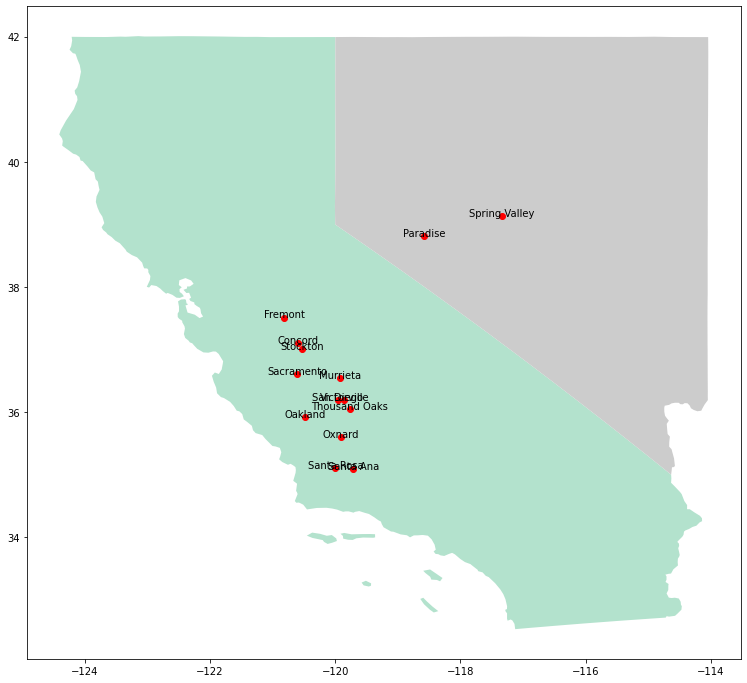

In [25]:
states = geopandas.read_file(filenameshp)
# which states shall we plot?
statelist = ['CA', 'NV']
# Make a geoseries with the names and predicted locations of each city.
# The  cities are in X_{lat,lng}_test so  we can just choose one.
# Then we need the predicted lat and lng from the model results.
plotdf = pd.concat([X_lat_test, uscities_full['population'], y_lat_pred, y_lng_pred], axis=1, join='inner') # pull back uscities to get population
plotdf = plotdf[plotdf['state_id'].isin(statelist)]
plotdf = plotdf[plotdf['population']>200_000]
plotdf = plotdf.sort_values(by=['population'], ascending=False)

gdf = geopandas.GeoDataFrame(
    plotdf, geometry=geopandas.points_from_xy(plotdf['lng'], plotdf['lat']))

# We plot each city in the relevant states as a red dot, on the map of the relevant states. 
# Then we add annotations : the  nme of each city.
outlinemap = states[states['STUSPS'].isin(statelist)].plot(cmap='Pastel2', figsize=(14, 12))
gdf.plot(ax=outlinemap, color='red')
gdf.apply(lambda x: outlinemap.annotate(text=x['city_ascii'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

In [ ]:
# For no sentence embeddings,we see that the model  puts cities roughly the centre of each state, because it
# has the state name to train from.
# The cities are not exactly on top of each other, because some city names are duplicated across the country, and this
# introduces some noise.


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")